In [35]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf as plt_pdf
from matplotlib.ticker import LogLocator, NullFormatter
import os


colors = sns.color_palette("tab10").as_hex()
colors = ["#402040"] + colors
palette = {
    "noir": colors[0],
    "noir-shared": colors[0],
    "noir-ad-hoc": colors[0],
    "noir-tls": colors[1],
    "noir-tls-ref": colors[2],
    "omp": colors[4],
    "mpi": colors[4],
    "mpi-mmap": colors[4],
    "mpi-opemp": colors[4],
    "rayon": colors[3],
    "flink": colors[2],
    "timely": colors[5],
    "ideal": colors[8],
    "linear": colors[8],
}
dash_list = [
    (0, (1, 10)),
    (0, (1, 1)),
    (0, (1, 1)),
    (5, (10, 3)),
    (0, (5, 10)),
    (0, (5, 5)),
    (0, (5, 1)),
]
lines = {
    "noir": dash_list[0],
    "noir-shared": dash_list[0],
    "noir-ad-hoc": dash_list[0],
    "omp": dash_list[1],
    "mpi": dash_list[1],
    "mpi-mmap": dash_list[1],
    "mpi-opemp": dash_list[1],
    "flink": dash_list[2],
    "timely": dash_list[3],
    "rayon": dash_list[4],
    "ideal": dash_list[5],
    "linear": dash_list[5],
}
hue_kws = {'color': palette, "ls" : lines}

linestyles = ["-", "--", ":", "-."]
sns.set_theme(context='paper', style='whitegrid', palette="tab10", font='Hack', font_scale=2.6125)

In [36]:
# ../bench-multi/gen_csv.py ../../results/raw/multi/ -o ../../results/csv/multi.csv

In [37]:
df = pd.read_csv("../../results/csv/multi.csv", dtype={"system": "string", "experiment": "string"})
df["system"][df["system"] == "rstream2"] = "noir"
df["cpu"] = df["num_hosts"] * df["procs_per_host"]
df = df[~df["system"].isin(["noir-tcp"])]
print(df.info())


<class 'pandas.core.frame.DataFrame'>
Index: 134 entries, 0 to 187
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   system          134 non-null    string 
 1   run             134 non-null    int64  
 2   experiment      134 non-null    string 
 3   num_hosts       134 non-null    int64  
 4   procs_per_host  134 non-null    int64  
 5   time            134 non-null    float64
 6   cpu             134 non-null    int64  
dtypes: float64(1), int64(4), string(2)
memory usage: 8.4 KB
None


In [38]:
su = df.groupby(["system", "experiment", "cpu"])[["time"]].mean().reset_index()

def compute_speedup(g):
    m = g.idxmin()["cpu"]
    g["speedup"] = g.loc[m]["time"] / g["time"]
    return g

su["speedup"] = su.groupby(["system", "experiment"])[["cpu", "time"]].apply(compute_speedup).reset_index()["speedup"]


print(su.head())

with open("../../results/csv/multi-human-readable.csv", "w") as f:
    su.to_csv(f)


     system            experiment  cpu       time   speedup
0  noir-tls  kmeans-30c-30it-200M   16   3.794865  1.000000
1  noir-tls  kmeans-30c-30it-200M   24   2.988639  1.269764
2  noir-tls  kmeans-30c-30it-200M   32   2.750217  1.379842
3  noir-tls                    q3   16  10.608781  1.000000
4  noir-tls                    q3   32   9.162602  1.157835


In [39]:
def _time_plot(data, experiments, systems=None):
    if systems is not None:
        data = data[data["system"].isin(systems)]
    data = data[data["experiment"].isin(experiments)]

    g = sns.relplot(data=data, x="cpu", y="time", hue="system", style="system", col="experiment", kind="line",
                    err_style="band", errorbar=("ci", 90), linewidth=3, palette=palette, aspect=1.125,  facet_kws={"legend_out": False, "despine": False})
    g.set_titles(template="")
    g.set_axis_labels(x_var="cpu cores(total)", y_var="execution time[s]")
    plt.tight_layout()
    leg = plt.legend(frameon=False, labelspacing=0.1)
    for line in leg.get_lines():
        line.set_linewidth(3.0)
    plt.xticks([x for x in range(8, 32+1, 8)])

def time_plot(data, experiments, systems=None):
    _time_plot(data, experiments, systems)
    plt.ylim((0, None))

def time_plot_log(data, experiments, systems=None):
    _time_plot(data, experiments, systems)
    plt.semilogy()
    plt.grid(True,which="both", c='lightgray')  

    locmin = LogLocator(base=10, subs=np.arange(0.1,1,0.1),numticks=10)
    ax = plt.gca()
    ax.yaxis.set_minor_locator(locmin)
    ax.yaxis.set_minor_formatter(NullFormatter())


In [40]:
def speedup_plot(data, experiments, systems=None, ideal_ref=8, x_step=8):
    if systems is not None:
        data = data[data["system"].isin(systems)]
    data = data[data["experiment"].isin(experiments)]

    x_max = data["cpu"].max()
    y_max = data["speedup"].max()
    ideal_max = x_max / ideal_ref
    ideal_name = "linear"

    for ex in experiments:
        ideal = pd.DataFrame([[ideal_name, ex, ideal_ref, 1], [
                             ideal_name, ex, x_max, ideal_max]], columns=["system", "experiment", "cpu", "speedup"])
        data = pd.concat([data, ideal], ignore_index=True)

    y_min = data["speedup"].min()
    y_max = max(y_max, ideal_max)

    g = sns.relplot(data=data, x="cpu", y="speedup", hue="system", style="system", col="experiment", kind="line",
                     err_style="bars", errorbar=("ci", 90), linewidth=3, palette=palette, aspect=1.125, facet_kws={"legend_out": False, "despine": False})
    g.set_titles(template="")
    g.set_axis_labels(x_var="cpu cores(total)", y_var="speedup")
    # plt.ylim((y_min, y_max))
    leg = plt.legend(frameon=False, labelspacing=0.1, loc="upper left")
    for line in leg.get_lines():
        line.set_linewidth(3.0)
    plt.tight_layout()
    plt.xticks([x for x in range(x_step, x_max+1, x_step)])
    # sns.move_legend(ax, loc="upper left", bbox_to_anchor=(0.2, 1))


/home/dema/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dema/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dema/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dema/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.

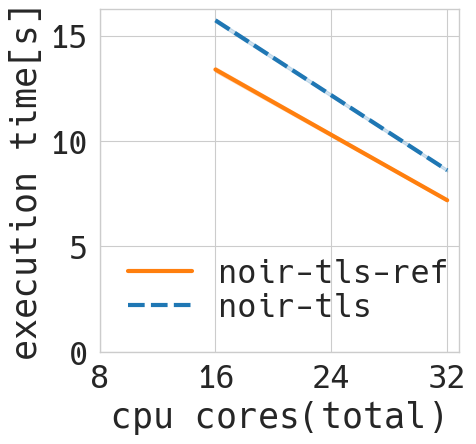

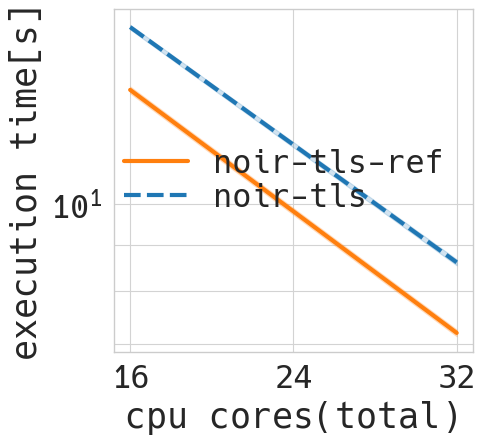

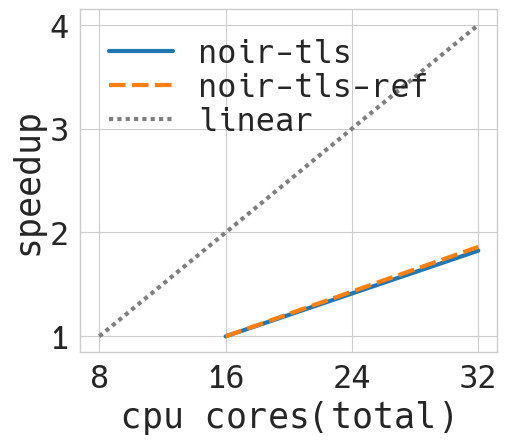

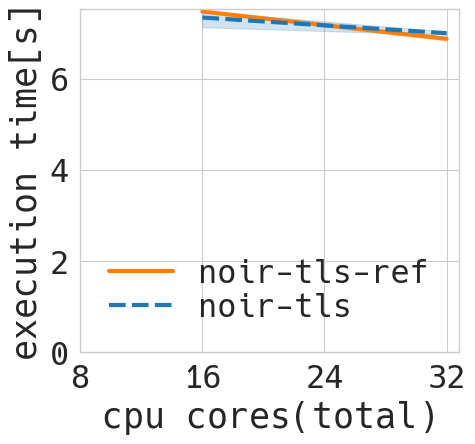

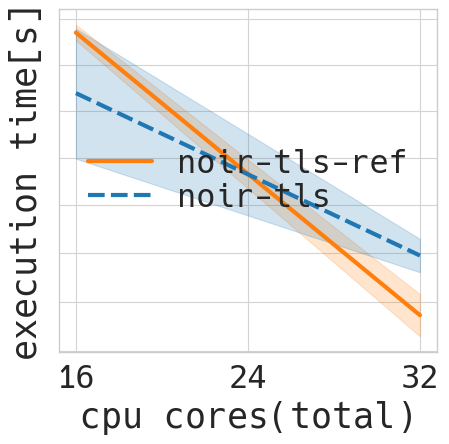

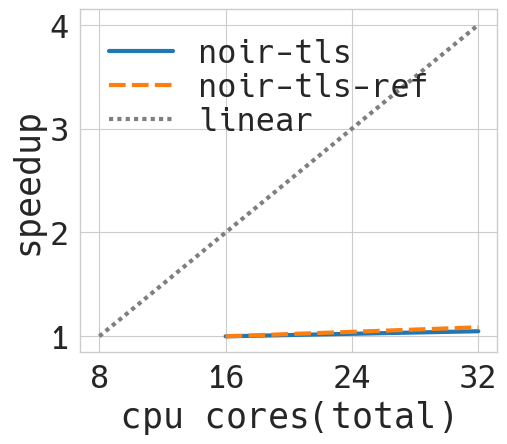

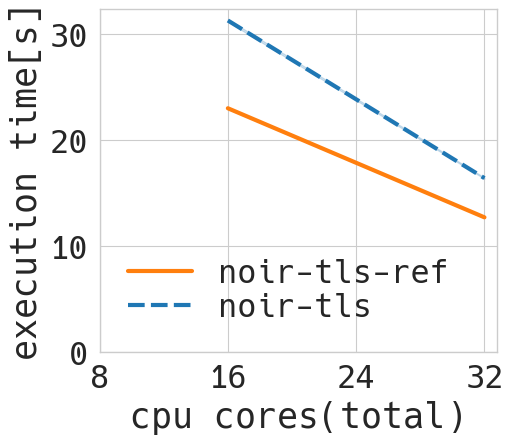

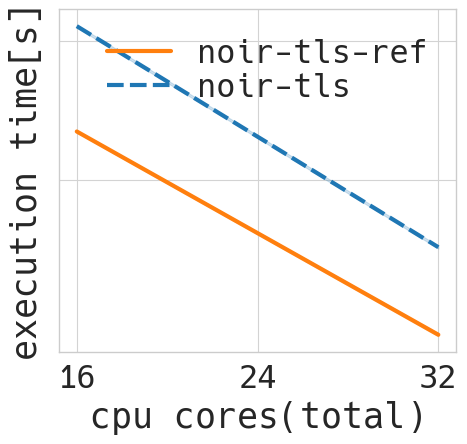

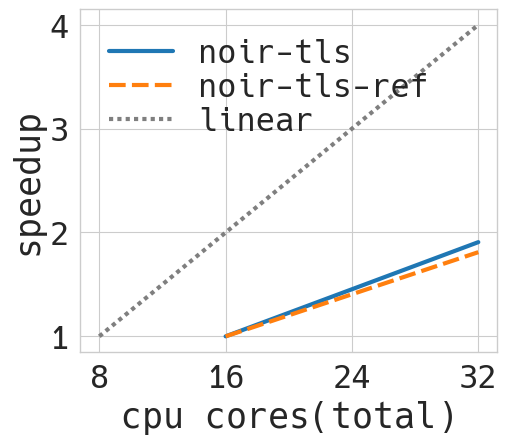

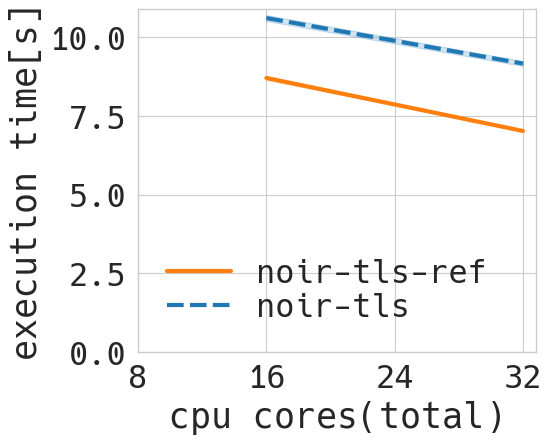

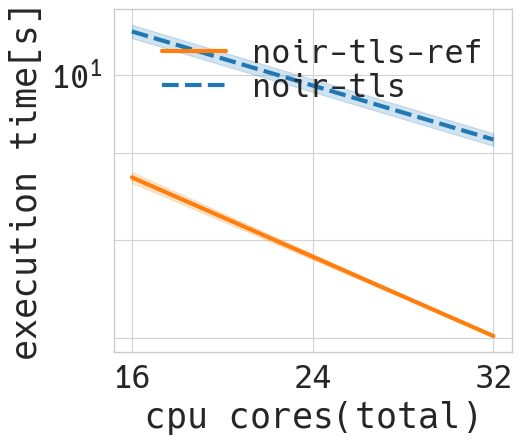

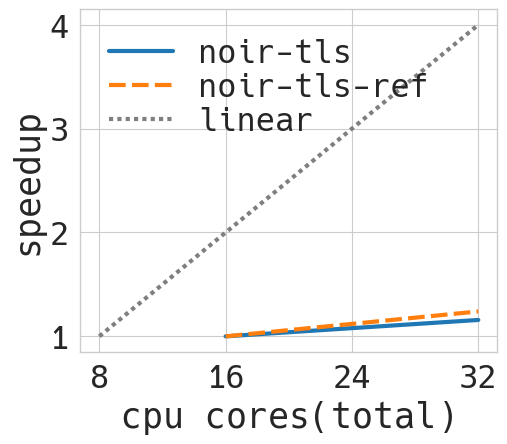

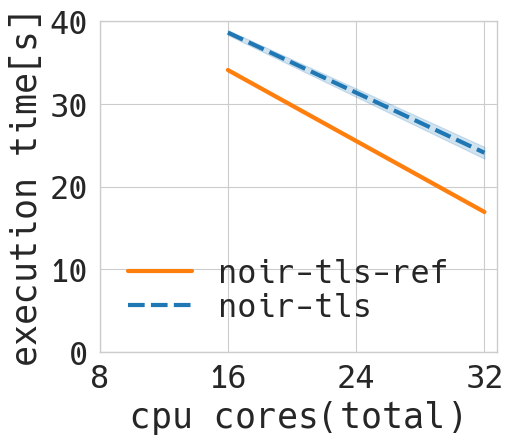

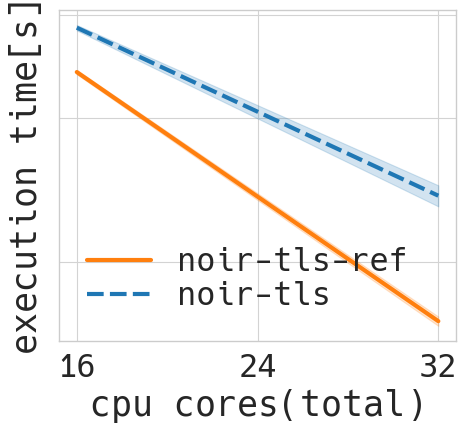

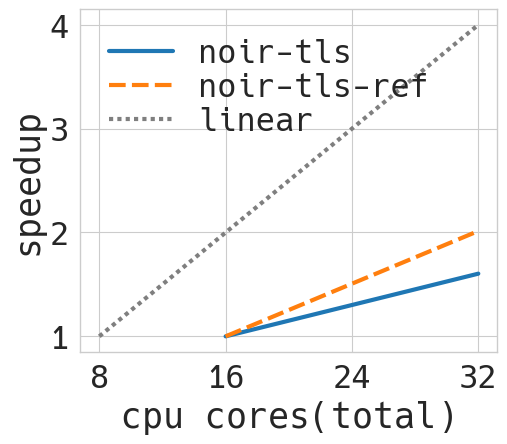

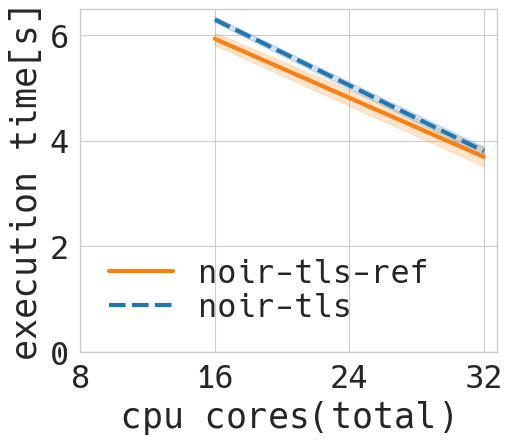

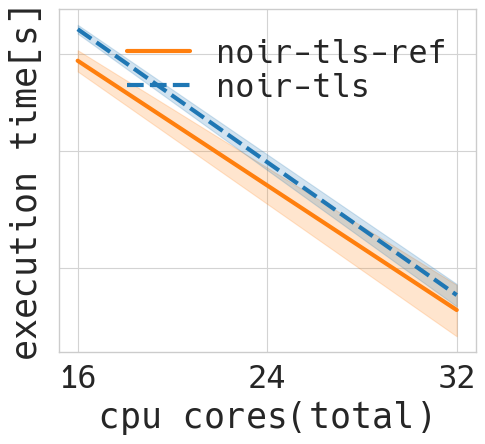

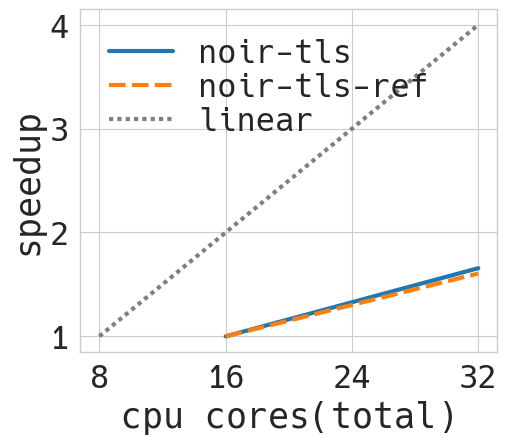

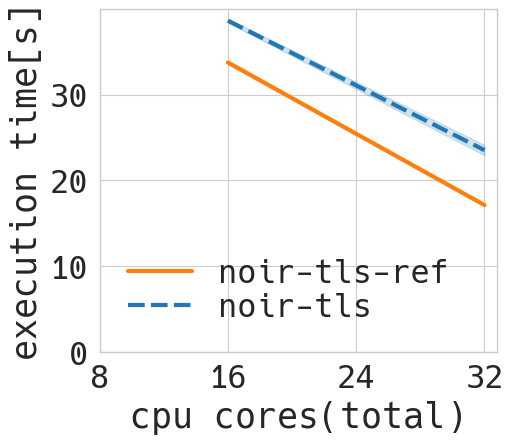

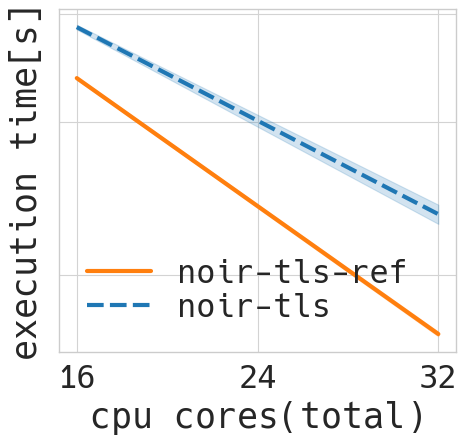

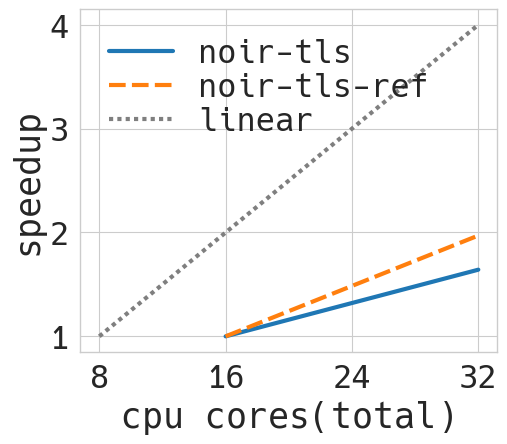

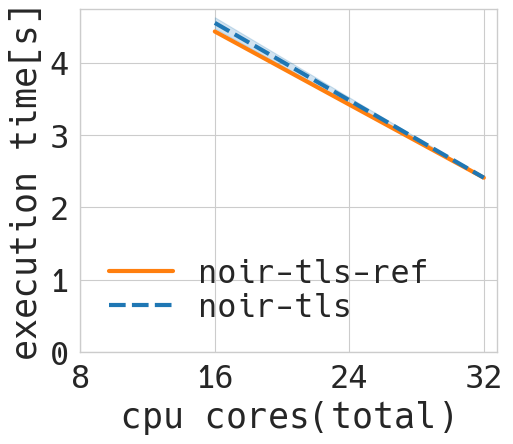

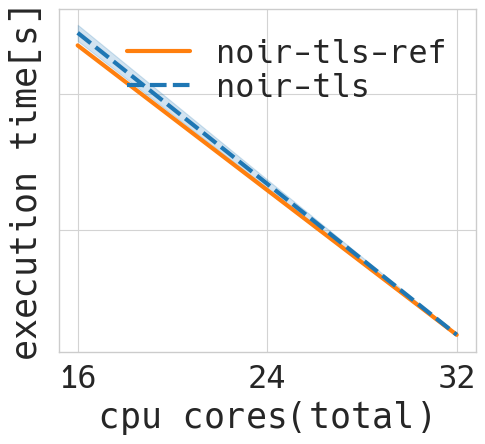

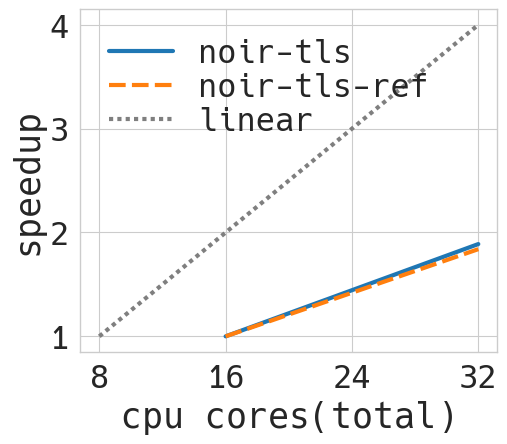

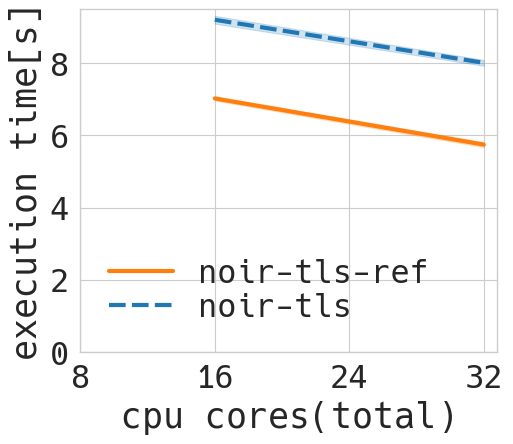

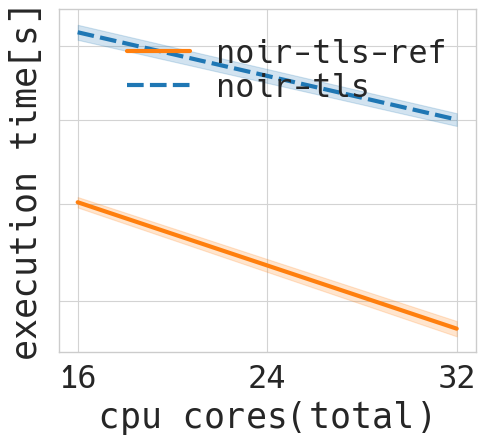

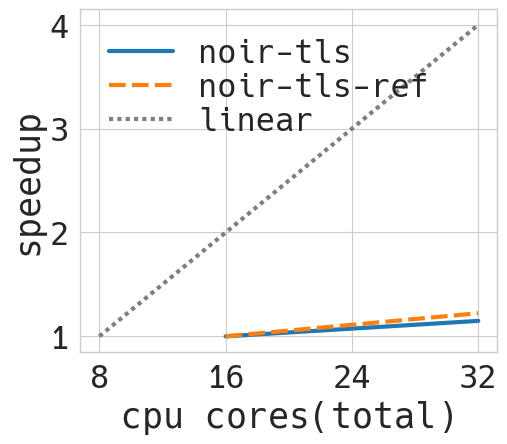

In [41]:
exp = ["connected-components"]
systems = None

# time_plot(df, exp, systems)
# speedup_plot(su, exp, systems)

def save_plot(exp, systems=None, basepath = "./plots"):
    path = f"{basepath}/{'-'.join(exp)}"
    if not os.path.exists(path):
        os.makedirs(path)

    time_plot(df, exp, systems)
    plt.savefig(f"{path}/time.pdf", bbox_inches="tight")
    time_plot_log(df, exp, systems)
    plt.savefig(f"{path}/time-log.pdf", bbox_inches="tight")
    speedup_plot(su, exp, systems)
    plt.savefig(f"{path}/scaling.pdf", bbox_inches="tight")

plots = [
    # ["kmeans-30c-30it-200M"],
    # ["kmeans-300c-30it-200M"],
    # ["kmeans-30c-30it-2000M"],
    # ["car-accidents"],
    # ["connected-components"],
    # ["enum-triangles"],
    # ["pagerank"],
    # ["pagerank-timely"],
    # ["pagerank-mpi"],
    # ["transitive-closure"],
    ["wordcount-re"],
    ["wordcount-opt"],
    ["wordcount-nonassoc"],
    ["q3"],
    ["q4"],
    ["q5"],
    ["q6"],
    ["q7"],
    ["q8"],
]

# save_plot(["kmeans-30c-30it-200M", "kmeans-300c-30it-200M", "kmeans-30c-30it-2000M"], ["noir", "mpi"])

for exp in plots:
    save_plot(exp)

/home/dema/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dema/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dema/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dema/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.

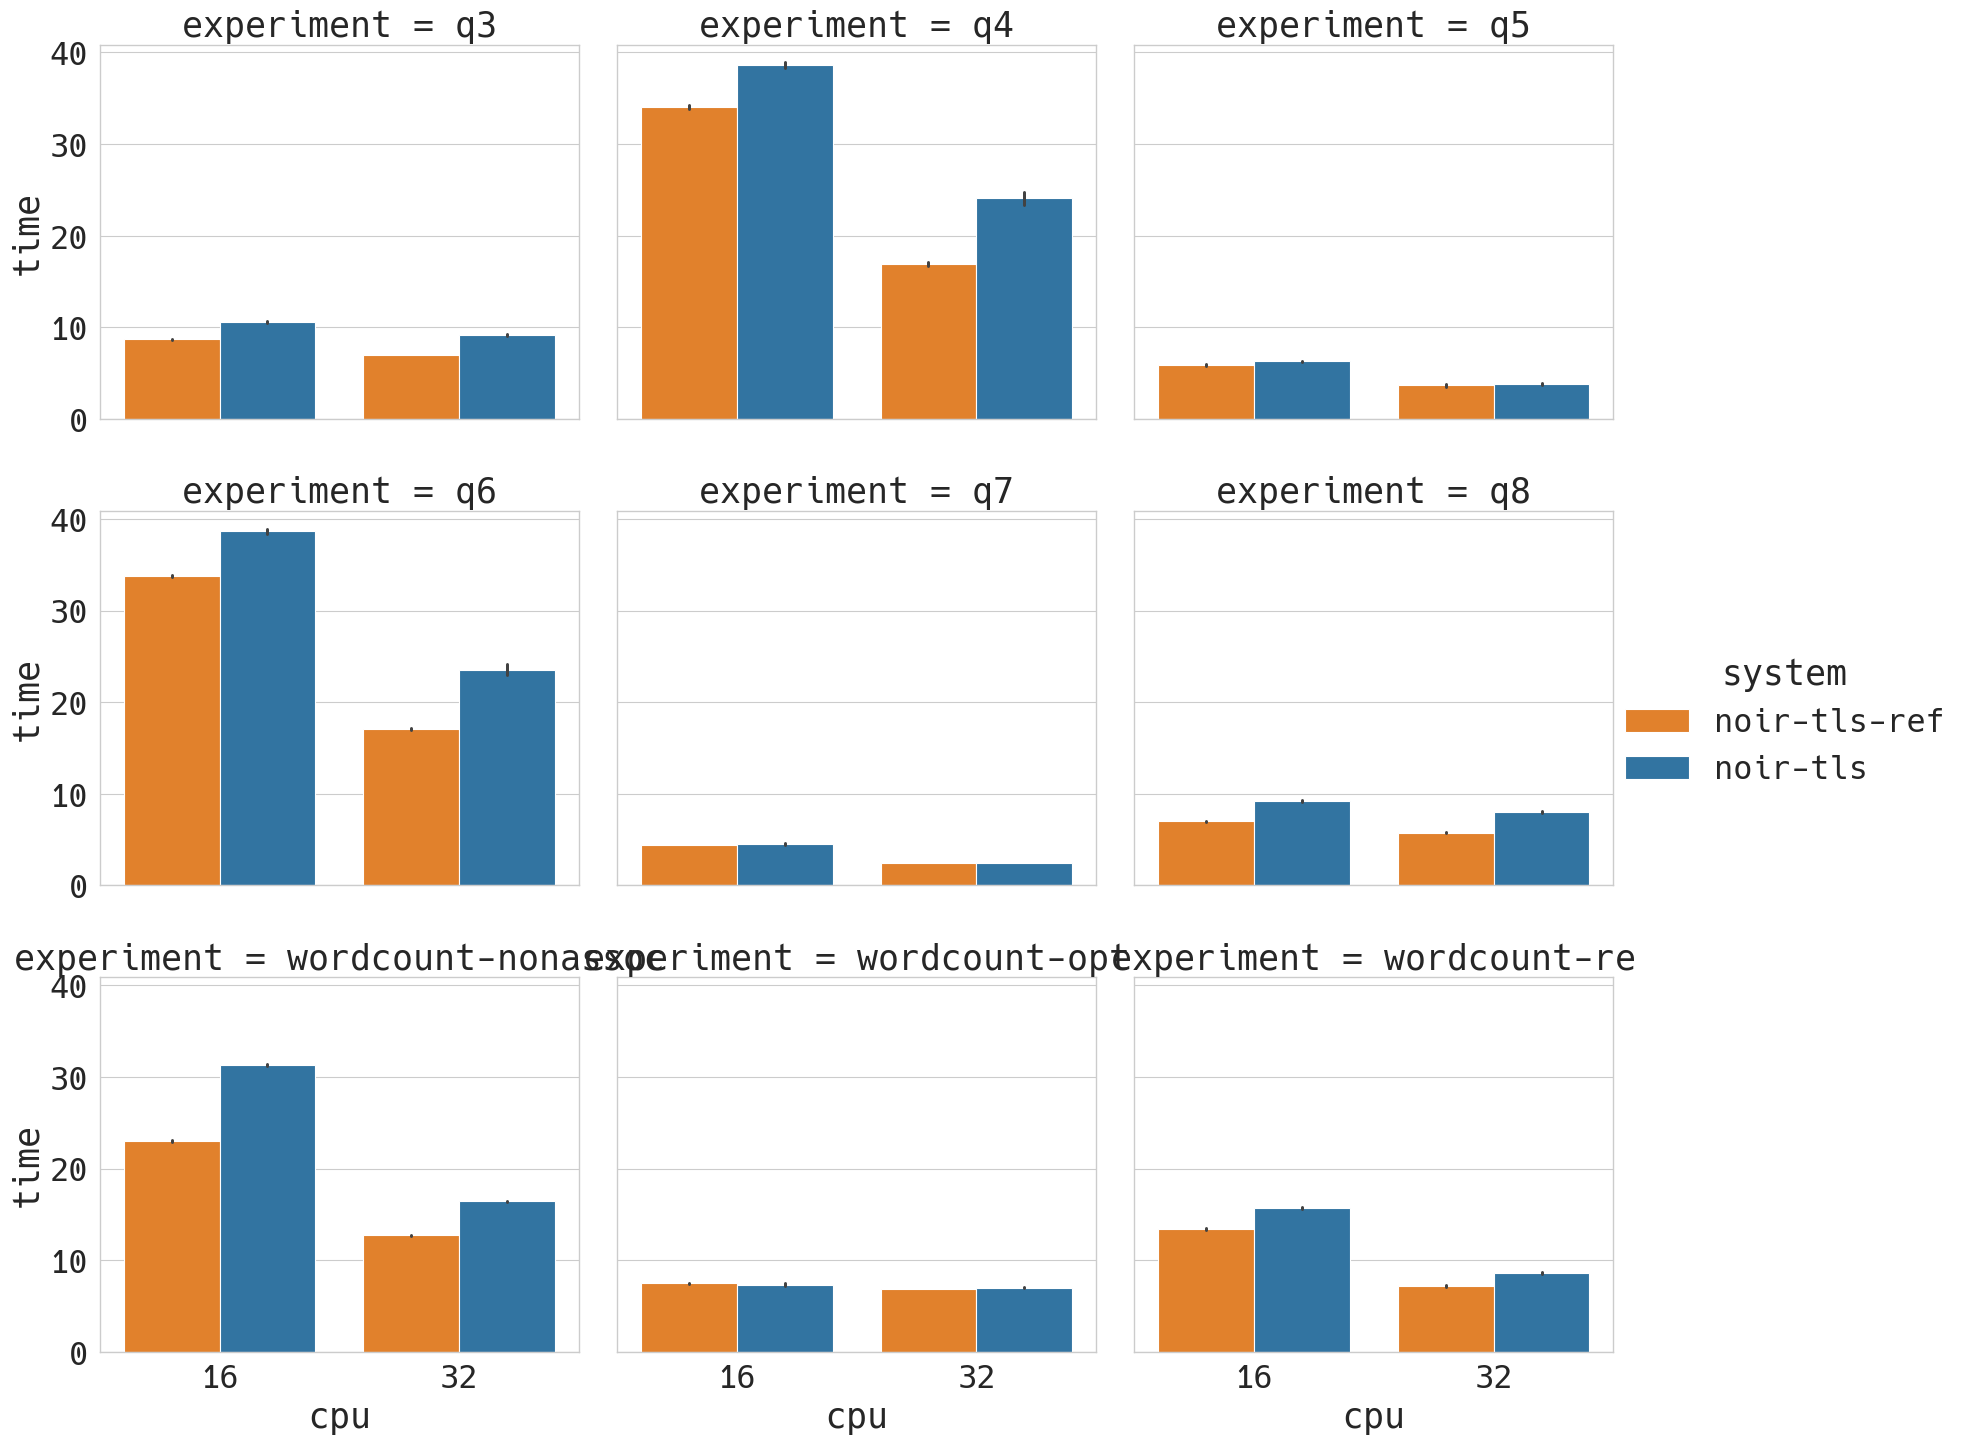

In [59]:
sns.catplot(data=df[~df["experiment"].isin(["q0", "q1", "q2", "kmeans-30c-30it-200M"])], x="cpu", y="time", hue="system", col="experiment", col_wrap=3, kind="bar",
                    errorbar=("ci", 90), palette=palette, aspect=1.125,  facet_kws={"legend_out": False, "despine": False})


In [42]:
# df = df[df["experiment"].isin([
#     "kmeans-30c-30it-200M",
#     "kmeans-300c-30it-200M",
#     "kmeans-30c-30it-2000M",
#     "car-accidents",
#     "connected-components",
#     "enum-triangles",
#     "pagerank",
#     "pagerank-timely",
#     "pagerank-mpi",
#     "transitive-closure",
#     "wordcount-re",
#     "wordcount-opt",
# ])]
# df = df[df["system"].isin([
#     "noir",
#     "flink",
#     "timely",
#     "mpi",
#     "mpi-mmap",
# ])]

# df = df.sort_values(["system", "experiment"])

# su = su[su["experiment"].isin([
#     "kmeans-30c-30it-200M",
#     "kmeans-300c-30it-200M",
#     "kmeans-30c-30it-2000M",
#     "car-accidents",
#     "connected-components",
#     "enum-triangles",
#     "pagerank",
#     "pagerank-timely",
#     "pagerank-mpi",
#     "transitive-closure",
#     "wordcount-re",
#     "wordcount-opt",
# ])]
# su = su[su["system"].isin([
#     "noir",
#     "flink",
#     "timely",
#     "mpi",
#     "mpi-mmap",
# ])]

# su = su.sort_values(["system", "experiment"])

# def grouper(iterable, n, fillvalue=None):
#     "Collect data into fixed-length chunks or blocks"
#     # grouper('ABCDEFG', 3, 'x') --> ABC DEF Gxx"
#     from itertools import zip_longest
#     args = [iter(iterable)] * n
#     return zip_longest(*args, fillvalue=fillvalue)


# pdf = plt_pdf.PdfPages("plots/combined-time.pdf")
# N_plots_per_page = 12
# for cols in grouper(df['experiment'].unique(), N_plots_per_page):
#     g = sns.relplot(data=df, x="cpu", y="time", hue="system", style="system", col="experiment", col_order=cols, kind="line",
#                     col_wrap=6,
#                     err_style="band", errorbar=("ci", 90), linewidth=3, palette=palette, aspect=1.125, facet_kws={"legend_out": True, "sharey": False})
#     g.set_titles(template="{col_name}")
#     plt.ylim((0, None))
#     # plt.tight_layout()
#     plt.xticks([x for x in range(8, 32+1, 8)])
#     pdf.savefig(g.fig)
# pdf.close()

# pdf = plt_pdf.PdfPages("plots/combined-time-log.pdf")
# N_plots_per_page = 12
# for cols in grouper(df['experiment'].unique(), N_plots_per_page):
#     g = sns.relplot(data=df, x="cpu", y="time", hue="system", style="system", col="experiment", col_order=cols, kind="line",
#                     col_wrap=6,
#                     err_style="band", errorbar=("ci", 90), linewidth=3, palette=palette, aspect=1.125, facet_kws={"legend_out": True, "sharey": False})
#     g.set_titles(template="{col_name}")
#     g.set(yscale="log")
#     # plt.tight_layout()
#     plt.xticks([x for x in range(8, 32+1, 8)])
#     pdf.savefig(g.fig)
# pdf.close()


# pdf = plt_pdf.PdfPages("plots/combined-scaling.pdf")
# N_plots_per_page = 12
# for cols in grouper(df['experiment'].unique(), N_plots_per_page):
#     ideal_ref=8
#     x_step=8

#     data = su
#     x_max = data["cpu"].max()
#     y_max = data["speedup"].max()
#     ideal_max = x_max / ideal_ref
#     ideal_name = "linear"

#     for ex in data["experiment"].unique():
#         ideal = pd.DataFrame([[ideal_name, ex, ideal_ref, 1], [
#                              ideal_name, ex, x_max, ideal_max]], columns=["system", "experiment", "cpu", "speedup"])
#         data = pd.concat([data, ideal], ignore_index=True)

#     y_min = data["speedup"].min()
#     y_max = max(y_max, ideal_max)

#     g = sns.relplot(data=data, x="cpu", y="speedup", hue="system", style="system", col="experiment", col_order=cols, kind="line",
#                     col_wrap=6,
#                     err_style="bars", errorbar=("ci", 90), linewidth=3, palette=palette, aspect=1.125, facet_kws={"legend_out": True})
#     g.set_titles(template="{col_name}")
#     # plt.tight_layout()
#     plt.xticks([x for x in range(8, 32+1, 8)])
#     pdf.savefig(g.fig)
# pdf.close()
